# Mesh 2-pt calculations

This package includes mesh-based power spectrum and correlation function estimation.

## Power spectrum and correlation function from mesh

In [1]:
# Let's create some mock mesh!
import jax
from jax import numpy as jnp
from jaxpower import MeshAttrs, Spectrum2Poles, generate_anisotropic_gaussian_mesh
meshsize = 128

def get_theory(kmax=0.3, dk=0.001):
    # Return theory power spectrum
    from cosmoprimo.fiducial import DESI
    cosmo = DESI(engine='eisenstein_hu')
    z = 1.
    pk1d = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
    ellsin = (0, 2, 4)
    edgesin = jnp.arange(0., kmax, dk)
    edgesin = jnp.column_stack([edgesin[:-1], edgesin[1:]])
    kin = (edgesin[..., 0] + edgesin[..., 1]) / 2.
    f, b = cosmo.growth_rate(z), 1.5
    beta = f / b
    shotnoise = (1e-3)**(-1)
    pk = pk1d(kin)
    poles = jnp.array([(1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pk + shotnoise,
                        0.99 * (4. / 3. * beta + 4. / 7. * beta ** 2) * pk,
                        8. / 35 * beta ** 2 * pk])
    return Spectrum2Poles(k=[kin] * len(ellsin), edges=[edgesin] * len(ellsin), num=list(poles), num_shotnoise=shotnoise, ells=ellsin)


mattrs = MeshAttrs(boxsize=1000., meshsize=meshsize)
poles = get_theory(4 * mattrs.knyq.max())
mesh = generate_anisotropic_gaussian_mesh(mattrs, poles, los='z', seed=68, order=1, unitary_amplitude=True)
print(mesh)

/local/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


RealMeshField(attrs=MeshAttrs(meshsize=staticarray([128, 128, 128], dtype=int32), boxsize=Array([1000., 1000., 1000.], dtype=float32), boxcenter=Array([0., 0., 0.], dtype=float32), dtype=dtype('float32'), fft_engine='jaxdecomp'))


In [2]:
# Now compute power spectrum
from jaxpower import compute_mesh2_spectrum, BinMesh2Spectrum

# This can be instantiated once for many power spectrum calculations as long as they share the same MeshAttrs
bin = BinMesh2Spectrum(mattrs, edges={'step': 0.01}, ells=(0, 2, 4))

# One can jit the power spectrum calculation
compute = jax.jit(compute_mesh2_spectrum, static_argnames=['los'])

pk = compute(mesh, bin=bin, los='z')

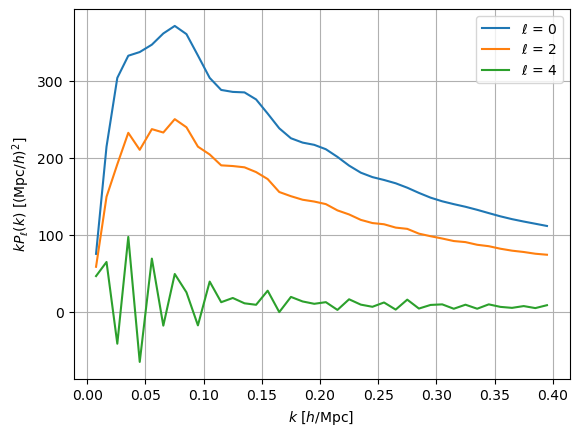

In [3]:
pk.plot(show=True);

In [4]:
# Interlude: the measurement
pk2 = pk.slice(slice(0, None, 2))  # rebin by a factor 2
pk2 = pk2.select(xlim=(0.05, 0.2))  # select 0.05 <= k [h/Mpc] < 0.2
pk2 = pk2.select(projs=[0, 2], select_projs=True)  # restrict to ell = 0, 2
pk2.view(projs=0)  # to view as an array
pk2.k(projs=0)  # k for ell = 0  (also: pk2.x(projs=0))
pk2.nmodes(projs=0)  # number of modes  (also: pk2.weights(projs=0))
pk2.edges(projs=0);  # edges

In [5]:
# Now compute correlation function
from jaxpower import compute_mesh2_correlation, BinMesh2Correlation

# This can be instantiated once for many correlation function calculations as long as they share the same MeshAttrs
bin = BinMesh2Correlation(mattrs, edges={'step': 5.}, ells=(0, 2, 4))

# One can jit the power spectrum calculation
compute = jax.jit(compute_mesh2_correlation, static_argnames=['los'])

xi = compute(mesh, bin=bin, los='z')

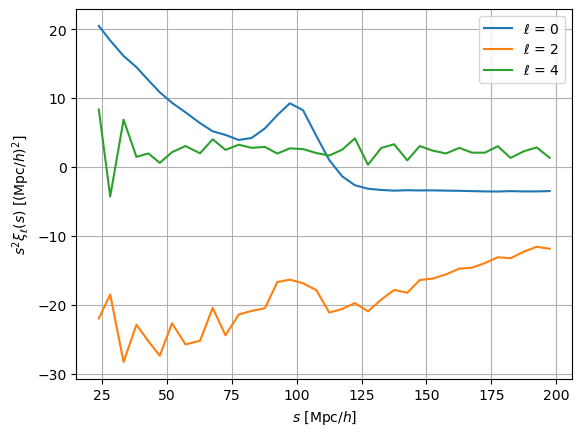

In [6]:
xi.select(xlim=(20., 200.)).plot(show=True);

In [7]:
# Everything above is transparently distributed
# Initialize JAX distributed environment
#jax.distributed.initialize()

# Let's simulate distributed calculation
from jaxpower import create_sharding_mesh

with create_sharding_mesh() as sharding_mesh:  # specify how to spatially distribute particles / mesh
    print('Sharding mesh {}.'.format(sharding_mesh))
    mesh = generate_anisotropic_gaussian_mesh(mattrs, poles, los='z', seed=68, order=1, unitary_amplitude=True)
    bin = BinMesh2Spectrum(mattrs, edges={'step': 0.01}, ells=(0, 2, 4))
    compute = jax.jit(compute_mesh2_spectrum, static_argnames=['los'])
    pk = compute(mesh, bin=bin, los='z')

# Close JAX distributed environment
#jax.distributed.shutdown()

Sharding mesh Mesh('x': 1, 'y': 1, axis_types=(Auto, Auto)).


## Power spectrum and correlation function from particles (FKP)

In [8]:
# Let's create some mock particles!
from jaxpower import generate_uniform_particles

mattrs = MeshAttrs(boxsize=1000., meshsize=meshsize, boxcenter=700.)
poles = get_theory(4 * mattrs.knyq.max())
# With local line-of-sight
mmesh = generate_anisotropic_gaussian_mesh(mattrs, poles, los='local', seed=68, order=1, unitary_amplitude=True)

# Generate particles in smaller volume
pattrs = mattrs.clone(boxsize=500.)
size = int(1e6)
data = generate_uniform_particles(pattrs, size, seed=42)
# Set weights = 1 + delta
data = data.clone(weights=1. + mmesh.read(data.positions, resampler='cic', compensate=True))

# Now randoms
randoms = generate_uniform_particles(pattrs, 2 * size, seed=43)

/local/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


In [9]:
from jaxpower import FKPField, compute_fkp2_spectrum_normalization, compute_fkp2_spectrum_shotnoise, get_mesh_attrs

# Define MeshAttrs from positions
mattrs = get_mesh_attrs(data.positions, randoms.positions, boxpad=2., meshsize=meshsize)

fkp = FKPField(data, randoms, attrs=mattrs)
norm, num_shotnoise = compute_fkp2_spectrum_normalization(fkp), compute_fkp2_spectrum_shotnoise(fkp)
# Paint particles to mesh
mesh = fkp.paint(resampler='tsc', interlacing=3, compensate=True, out='real')
del fkp
# Tip: can be done once for many P(k) evaluation
bin = BinMesh2Spectrum(mattrs, edges={'step': 0.01}, ells=(0, 2, 4))
# Then compute power spectrum
# One can jit the function
compute = jax.jit(compute_mesh2_spectrum, static_argnames=['los'])
pk = compute(mesh, bin=bin, los='firstpoint')
# Add the normalization and shot noise information
pk = pk.clone(norm=norm, num_shotnoise=num_shotnoise)

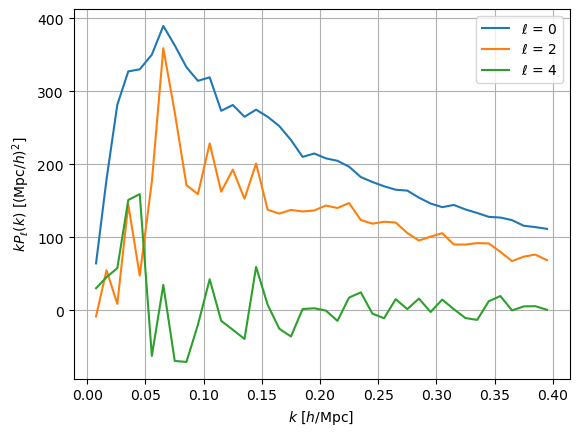

In [10]:
pk.plot(show=True);

In [11]:
# Now correlation function
bin = BinMesh2Correlation(mattrs, edges={'step': 5.}, ells=(0, 2, 4))

compute = jax.jit(compute_mesh2_correlation, static_argnames=['los'])
xi = compute(mesh, bin=bin, los='firstpoint')
xi = xi.clone(norm=norm, num_shotnoise=num_shotnoise)

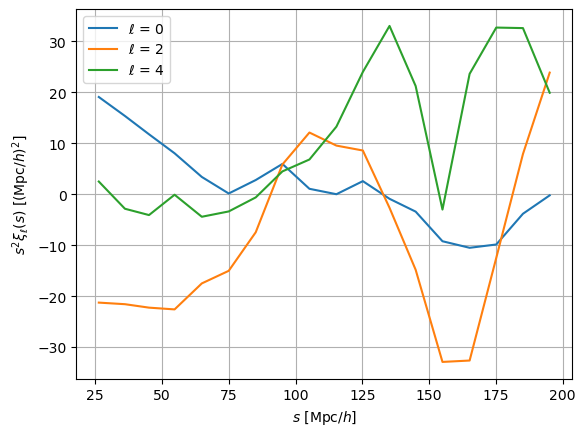

In [12]:
xi.select(xlim=(20., 200.)).plot(show=True);

In [13]:
# Initialize JAX distributed environment
#jax.distributed.initialize()

# Let's simulate distributed calculation
from jaxpower import create_sharding_mesh, exchange_particles, ParticleField

with create_sharding_mesh() as sharding_mesh:  # specify how to spatially distribute particles / mesh
    print('Sharding mesh {}.'.format(sharding_mesh))
    # Generate a Gaussian mock --- everything is already distributed
    mattrs = MeshAttrs(boxsize=1000., meshsize=meshsize, boxcenter=700.)
    mmesh = generate_anisotropic_gaussian_mesh(mattrs, poles, los='local', seed=68, order=1, unitary_amplitude=True)
    pattrs = mattrs.clone(boxsize=500.)
    size = int(1e6)
    data = generate_uniform_particles(pattrs, size, seed=42)
    data = data.clone(weights=1. + mmesh.read(data.positions, resampler='cic', compensate=True))
    randoms = generate_uniform_particles(pattrs, 2 * size, seed=43)

    # Now, pick MeshAttrs
    mattrs = get_mesh_attrs(data.positions, randoms.positions, boxpad=2., meshsize=meshsize)
    # Create ParticleField, exchanging particles
    data = ParticleField(data.positions, attrs=mattrs, exchange=True)  # or data.clone(exchange=True)
    randoms = ParticleField(randoms.positions, attrs=mattrs, exchange=True)

    # Now data and randoms are exchanged given MeshAttrs mattrs, we can proceed as normal
    fkp = FKPField(data, randoms, attrs=mattrs)
    norm, num_shotnoise = compute_fkp2_spectrum_normalization(fkp), compute_fkp2_spectrum_shotnoise(fkp)
    mesh = fkp.paint(resampler='tsc', interlacing=3, compensate=True, out='real')
    del fkp
    bin = BinMesh2Spectrum(mattrs, edges={'step': 0.01}, ells=(0, 2, 4))
    pk = compute(mesh, bin=bin, los='firstpoint')
    pk = pk.clone(norm=norm, num_shotnoise=num_shotnoise)

# Close JAX distributed environment
#jax.distributed.shutdown()

Sharding mesh Mesh('x': 1, 'y': 1, axis_types=(Auto, Auto)).


## Window matrix
Now let's estimate a window matrix.

In [14]:
# First compute the correlation of randoms
from jaxpower import BinMesh2Correlation, compute_mesh2_correlation, compute_smooth2_spectrum_window

sbin = BinMesh2Correlation(mattrs, edges={}, ells=list(range(0, 9, 2)))
# Normalize randoms to data and paint
randoms2 = data.sum() / randoms.sum() * randoms
mesh = randoms2.paint(resampler='tsc', interlacing=3, compensate=True, out='real')
num_shotnoise = compute_fkp2_spectrum_shotnoise(randoms2)
# Compute the correlation function multipoles of randoms, and normalize properly (removing shot noise from randoms)
xi = compute_mesh2_correlation(mesh, bin=sbin, los='firstpoint').clone(norm=norm, num_zero=None,
                                                                 num_shotnoise=num_shotnoise / mattrs.cellsize.prod())


In [15]:
theory = get_theory(kmax=mattrs.knyq.max(), dk=0.001)
edgesin, ellsin = theory.edges(0), theory.projs  # we just need to pass in the theory edges
wmatrix = compute_smooth2_spectrum_window(xi, edgesin=edgesin, ellsin=ellsin, bin=bin)

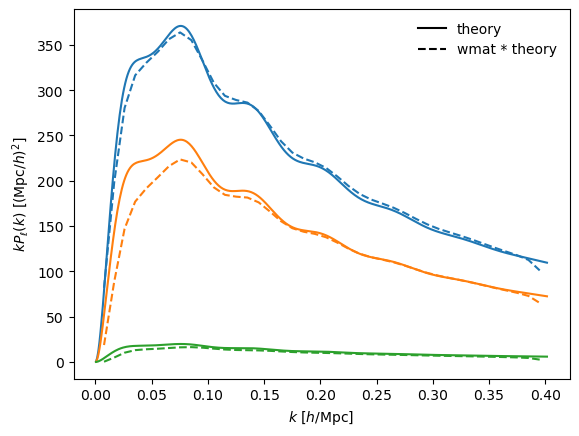

In [16]:
# Compute the dot product window matrix dot theory
pkc = wmatrix.dot(theory, return_type=None, zpt=None)

from matplotlib import pyplot as plt
ax = plt.gca()
ax.plot([], [], color='k', linestyle='-', label='theory')
ax.plot([], [], color='k', linestyle='--', label='wmat * theory')

for iproj, proj in enumerate(pk.projs):
    color = 'C{:d}'.format(iproj)
    k = theory.x(projs=proj)
    ax.plot(k, k * theory.view(projs=proj), color=color, linestyle='-')
    k = pkc.x(projs=proj)
    ax.plot(k, k * pkc.view(projs=proj), color=color, linestyle='--')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(loc=1, frameon=False)
plt.show()